# Project Airbnb (Step 3)
---

## Model and prediction process

## Agenda

1. Imports
2. Data reading
3. Data cleaning and feature selection  
4. Regression models
5. Time series price prediction
6. Conclusion and recommendations 

### 1. Imports:
---

In [ ]:
# ! pip install ephem
# ! pip install fbprophet
# !conda install -c conda-forge fbprophet -y

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.stattools import adfuller # Import Augmented Dickey-Fuller test.

from statsmodels.tsa.ar_model import AR, AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARIMA

from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse, mse 

import warnings
warnings.simplefilter(action="ignore")
plt.style.use('seaborn-whitegrid')


### 2. Data reading:
---

In [2]:
pd.set_option('display.max_columns', None)
listing= pd.read_json('../data/listing_clean.json')
reservations_df =pd.read_json('../data/reservations_clean.json')

In [ ]:
listing.head(1)

In [ ]:
reservations_df.head(1)

In [ ]:
listing.dtypes

### 3. Feature selection and features graphics:
---

In [3]:
data=listing[['neighbourhood_group_cleansed','latitude','longitude','room_type','host_is_superhost',
             'accommodates','bedrooms','beds','bathroom','number_of_reviews','price']].copy()

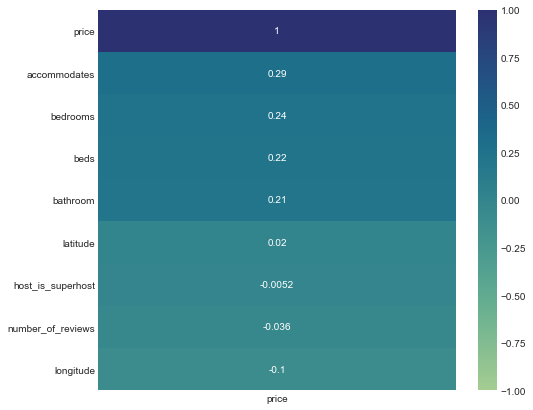

In [4]:
plt.figure(figsize=(8, 7))
sns.heatmap(data.corr()
            [['price']].sort_values(
                by='price', ascending=False),
            vmin=-1,
            vmax=1, 
            annot=True, 
            cmap="crest");
plt.savefig('../assets/correlation.png')

In [ ]:
corr =data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 9))
sns.heatmap(data.corr(),vmin=-1,
    vmax=1,
    cmap="crest",
    mask=mask,
    center=None,
    robust=False,
    annot=True,
    annot_kws=None,
    linecolor='white',
    square=True,);

In [ ]:
data.head(3)

In [ ]:
data.describe()

In [ ]:
# Dropping price values higher than 7000
data.drop(data[data['price']>=7000].index,inplace=True)

In [ ]:
#creating two new features
data['amenities_count'] = listing['amenities'].apply(lambda x: len(x.split(',')))
# Instantiate Sentiment Intensity Analyzer
sent =SentimentIntensityAnalyzer()
data['sent']=listing['description'].apply(lambda i : sent.polarity_scores(i)['compound'])

In [ ]:
# Creating dummies
data_dummy = pd.get_dummies(data,columns=['room_type', 'neighbourhood_group_cleansed'], drop_first=True)
data_dummy.head(1)

In [ ]:
features = [col for col in data._get_numeric_data().columns if col != 'price']
X=data_dummy.drop('price',axis=1)
y=data_dummy['price']

In [ ]:
sns.pairplot(data, corner = True,palette="crest");

In [ ]:
plt.figure(figsize=(8, 7))
sns.heatmap(data.corr()
            [['price']].sort_values(
                by='price', ascending=False),
            vmin=-1, 
            vmax=1, 
            annot=True, 
            cmap="crest");

* When visualizing the first graph of heat for the correlation, we see that the values with respect to the price are not very good, after cleaning some data and creating a couple of new columns, the correlation between the variables could be improved a little. This gives us indications that the models are not going to perform in the best way.

### 4. Regression models price prediction:
---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42)

In [ ]:
X_train.shape, X_test.shape

In [ ]:
# Scale our data.
# Relabeling scaled data as "Z" is common.
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

#### - Linel regression:
---

In [ ]:
linreg = LinearRegression()
linreg.fit(Z_train, y_train)

In [ ]:
# Training Testing Cross Val
print(f'Cross validation training: {round(cross_val_score(linreg, Z_train, y_train,cv=5).mean(),5)}')
print(f'Cross validation test: {round(cross_val_score(linreg, Z_test, y_test,cv=5).mean(),5)}')

In [ ]:
# Training score R2
print(f'R-Squared score training: {round(linreg.score(Z_train, y_train),5)}')
print(f'R-Squared score test: {round(linreg.score(Z_test, y_test),5)}')

In [ ]:
#create predictions
train_preds = linreg.predict(Z_train)
test_preds = linreg.predict(Z_test)

In [ ]:
# MSE 
print(f'MSE training: {round(metrics.mean_squared_error(y_train, train_preds),2)}')
print(f'MSE testing: {round(metrics.mean_squared_error(y_test, test_preds),2)}')
print('*'*20)
# RMSE 
print(f'RMSE training: {round(metrics.mean_squared_error(y_train, train_preds, squared = False),2)}')
print(f'RMSE testing: {round(metrics.mean_squared_error(y_test, test_preds, squared = False),2)}')

In [ ]:
pd.DataFrame(list(zip(features, linreg.coef_)), columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

In [ ]:
plt.figure(figsize=(12, 7))
sns.scatterplot(y_test, test_preds);

* As we can see in this linear regression model, the cross validation value is 0.26 for training and 0.25 for testing, and an R squared of 0.26 for training and 0.24 for testing. This indicates that our model has a low performance and we can also is this a little overfitting. Looking at the RMSE values, we see that the error margin values are quite high, 178 for training and 167 for testing.
* When analyzing the table of coefficients, we see that the price of the listings increases by 64.33 for each unit that accommodates increases.

#### - Ridge:
---

In [ ]:
#Instantiate
ridge_model = Ridge(alpha=10)
ridge_model.fit(Z_train, y_train)

In [ ]:
# Evaluate model using R2.
print(f"Ridge Training R-Squared: {round(ridge_model.score(Z_train, y_train),5)}")
print(f"Ridge Testing R-Squared: {round(ridge_model.score(Z_test, y_test),5)}")

In [ ]:
#create predictions
train_preds = ridge_model.predict(Z_train)
test_preds = ridge_model.predict(Z_test)

In [ ]:
# MSE 
print(f'MSE training: {round(metrics.mean_squared_error(y_train, train_preds),2)}')
print(f'MSE testing: {round(metrics.mean_squared_error(y_test, test_preds),2)}')
print('*'*20)
# RMSE 
print(f'RMSE training: {round(metrics.mean_squared_error(y_train, train_preds, squared = False),2)}')
print(f'RMSE testing: {round(metrics.mean_squared_error(y_test, test_preds, squared = False),2)}')

* For this model (ridge) with alpha of 10, we see that it has not improved yet, it continues in a very low performance range to make good predictions.

#### - Lasso:
----

In [ ]:
#Instantiate
lasso_model = Lasso(alpha=20)
lasso_model.fit(Z_train, y_train)

In [ ]:
# Evaluate model using R2.
print(f"Lasso Training R-Squared: {round(lasso_model.score(Z_train, y_train),5)}")
print(f"Lasso Testing R-Squared: {round(lasso_model.score(Z_test, y_test),5)}")

In [ ]:
#create predictions
train_preds = lasso_model.predict(Z_train)
test_preds = lasso_model.predict(Z_test)

In [ ]:
# MSE 
print(f'MSE training: {round(metrics.mean_squared_error(y_train, train_preds),2)}')
print(f'MSE testing: {round(metrics.mean_squared_error(y_test, test_preds),2)}')
print('*'*20)
# RMSE 
print(f'RMSE training: {round(metrics.mean_squared_error(y_train, train_preds, squared = False),2)}')
print(f'RMSE testing: {round(metrics.mean_squared_error(y_test, test_preds, squared = False),2)}')

* using the Lasso model with alpha of 20, the model got worse in all the metrics

#### - Decision Tree:
----

In [ ]:
param_grid = {
     "max_depth":[2, 5, 10],
     "max_features":[6,8,10,12,14,16],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': range(2, 7),
    'max_leaf_nodes': range(2, 20)
}

dt = DecisionTreeRegressor()

grid_dt = GridSearchCV(estimator=dt,
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1,
                            verbose=2)

grid_dt.fit(Z_train, y_train)
grid_dt.best_estimator_

In [ ]:
dt = DecisionTreeRegressor(max_depth=5, max_features=14, min_samples_leaf=6,min_samples_split=20,max_leaf_nodes=18)
dt.fit(Z_train, y_train)
# Evaluate model using R2.
print(f"Training R-Squared: {round(dt.score(Z_train, y_train),5)}")
print(f"Testing R-Squared: {round(dt.score(Z_test, y_test),5)}")

In [ ]:
#create predictions
train_preds = dt.predict(Z_train)
test_preds = dt.predict(Z_test)
# MSE 
print(f'MSE training: {round(metrics.mean_squared_error(y_train, train_preds),2)}')
print(f'MSE testing: {round(metrics.mean_squared_error(y_test, test_preds),2)}')
print('*'*20)
# RMSE 
print(f'RMSE training: {round(metrics.mean_squared_error(y_train, train_preds, squared = False),2)}')
print(f'RMSE testing: {round(metrics.mean_squared_error(y_test, test_preds, squared = False),2)}')

In [ ]:
# Import plot_tree from sklearn.tree module.
# import matplotlib.pyplot as plt
# from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(100, 30))
tree.plot_tree(dt, fontsize=40,feature_names = X_train.columns,filled = True)
plt.show()

* The decision tree model did not perform better either. After trying to find the best parameters for the model, the R-squared and RMSE values were no better than previous models.

#### - Random forest:
----

In [ ]:
param_grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [100,200,300]}
rf_reg = RandomForestRegressor()

rf_reg_tuned = GridSearchCV(estimator=rf_reg,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

rf_reg_tuned.fit(Z_train, y_train)
rf_reg_tuned.best_estimator_

In [ ]:
rfr = RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=300)
rfr.fit(Z_train, y_train)
# Evaluate model using R2.
print(f"Training R-Squared: {round(rfr.score(Z_train, y_train),5)}")
print(f"Testing R-Squared: {round(rfr.score(Z_test, y_test),5)}")

In [ ]:
#create predictions
train_preds = rfr.predict(Z_train)
test_preds = rfr.predict(Z_test)
# MSE 
print(f'MSE training: {round(metrics.mean_squared_error(y_train, train_preds),2)}')
print(f'MSE testing: {round(metrics.mean_squared_error(y_test, test_preds),2)}')
print('*'*20)

# RMSE 
print(f'RMSE training: {round(metrics.mean_squared_error(y_train, train_preds, squared = False),2)}')
print(f'RMSE testing: {round(metrics.mean_squared_error(y_test, test_preds, squared = False),2)}')

In [ ]:
plt.figure(figsize=(12, 7))
sns.scatterplot(y_test, test_preds);

* After searching for the best parameters for the random forest model, it has been one of the models that has had the best performance, with the only drawback of this super overfitting.

### 4. Time serie price prediction:
---

In [ ]:
# Run ADF test data.
adfuller(reservations_df['price'])

In [ ]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [ ]:
# Run ADF test data.
interpret_dftest(adfuller(reservations_df['price']))


* the prediction model of the time series indicates that there is a stationary function, this is due to the fact that when running the test the p-value is greater than 0.5.

#### - Arima model:
----

In [54]:
train, test = train_test_split(reservations_df['price'],test_size = 0.25,shuffle = False)

In [55]:
train.shape, test.shape

((522,), (174,))

* Manual GridSearch

In [56]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(6):
    for q in range(6):

        # Insert try and except statements.
        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 0, {q})')

            
            arima = ARIMA(endog = train.astype(float).dropna(), # endog = Y var
                         order = (p, 0, q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()
            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},0,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},0,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 0, 0)
The AIC for ARIMA(0,0,0) is: 3742.7488849805604
Attempting to fit ARIMA(0, 0, 1)
The AIC for ARIMA(0,0,1) is: 3081.7015068455057
Attempting to fit ARIMA(0, 0, 2)
Attempting to fit ARIMA(0, 0, 3)
The AIC for ARIMA(0,0,3) is: 2391.390734626718
Attempting to fit ARIMA(0, 0, 4)
Attempting to fit ARIMA(0, 0, 5)
Attempting to fit ARIMA(1, 0, 0)
The AIC for ARIMA(1,0,0) is: 2145.3838495496875
Attempting to fit ARIMA(1, 0, 1)
The AIC for ARIMA(1,0,1) is: 2131.0847625129945
Attempting to fit ARIMA(1, 0, 2)
The AIC for ARIMA(1,0,2) is: 1906.0032907692976
Attempting to fit ARIMA(1, 0, 3)
The AIC for ARIMA(1,0,3) is: 1906.4548082949805
Attempting to fit ARIMA(1, 0, 4)
The AIC for ARIMA(1,0,4) is: 1891.591669205775
Attempting to fit ARIMA(1, 0, 5)
The AIC for ARIMA(1,0,5) is: 1879.2203144360763
Attempting to fit ARIMA(2, 0, 0)
The AIC for ARIMA(2,0,0) is: 2145.9574048166396
Attempting to fit ARIMA(2, 0, 1)
The AIC for ARIMA(2,0,1) is: 2054.40272969103
Attempting to 

In [57]:
# Instantiate best model.
model = ARIMA(endog = train.astype(float).dropna(), 
             order = (5,0,5)) # Endog = Y variable 


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds_train = arima.predict(start = train.index[0],end = train.index[-1])
preds = arima.predict(start = test.index[0],end = test.index[-1])

# MSE 
print(f'MSE training: {round(metrics.mean_squared_error(train, preds_train),2)}')
print(f'MSE testing: {round(metrics.mean_squared_error(test, preds),2)}')

# # RMSE 
print(f'RMSE training: {round(metrics.mean_squared_error(train, preds_train, squared = False),2)}')
print(f'RMSE testing: {round(metrics.mean_squared_error(test, preds, squared = False),2)}')

MSE training: 0.76
MSE testing: 10.19
RMSE training: 0.87
RMSE testing: 3.19


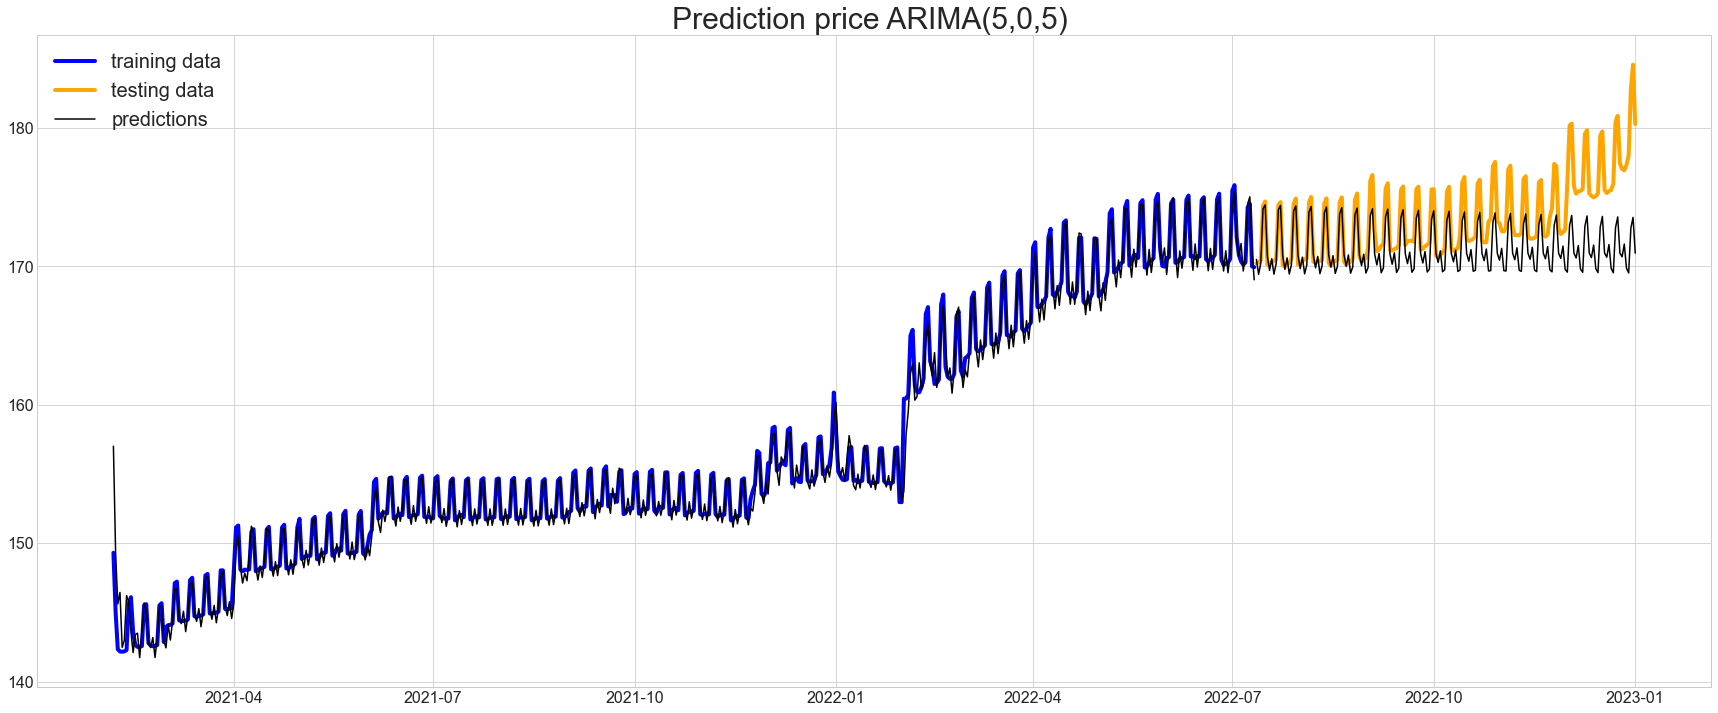

In [76]:
# Plot data.
plt.figure(figsize=(30,12))

plt.plot(train.index, pd.DataFrame(train), color = 'blue',linewidth =4)# Plot training data.
plt.plot(test.index, pd.DataFrame(test), color = 'orange',linewidth =4)# Plot testing data.
plt.plot(test.index, preds, color = 'black',linestyle='-')# Plot predicted test values.
plt.plot(train.index, preds_train, color = 'black',linestyle='-')# Plot predicted test values.

plt.title(label = 'Prediction price ARIMA(5,0,5) ', fontsize=30)
plt.legend(['training data','testing data','predictions'],fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show();

In [82]:
df_predictions=pd.DataFrame([test,preds]).T
df_predictions.columns=['price','predictions']
df_predictions

,price,predictions
2022-07-12,170.211308,170.498552
2022-07-13,170.289674,169.425841
2022-07-14,170.450913,170.230030
2022-07-15,174.369141,174.154001
2022-07-16,174.682605,174.440148
...,...,...
2022-12-28,177.325255,169.870177
2022-12-29,178.026148,169.520832
2022-12-30,182.766028,172.756131
2022-12-31,184.568790,173.534948


* creating a function to search for the best parameters, we found that the best values were 5,0,5, and an Akaike Information Critera (AIC) of 1214.67, when filling the model with these parameters, we found that the values of MSE and RMSE for training they are good, but on the other hand when we analyze the test values we see that the values are much larger.
* Analyzing the graph we see that when we predict the test values, the model after a while cannot predict the trend and starts to predict the average price.


#### - fbprophet model:
----

In [88]:
reservations_df

,available,price,weekday
2021-02-05,3847,149.310480,Friday
2021-02-06,9204,145.043317,Saturday
2021-02-07,11242,142.344009,Sunday
2021-02-08,12248,142.182521,Monday
2021-02-09,12496,142.167703,Tuesday
...,...,...,...
2022-12-28,13181,177.325255,Wednesday
2022-12-29,13164,178.026148,Thursday
2022-12-30,13133,182.766028,Friday
2022-12-31,13151,184.568790,Saturday


In [89]:
#split the data en train and test
train, test = train_test_split(reservations_df.reset_index(),test_size = 0.25,shuffle = False)

#rename the the columns for train and test
train= train[['index','price']]
train.columns= ['ds', 'y']

test= test[['index','price']]
test.columns= ['ds', 'y']



In [90]:
#Instantiate and fitting the model.
m= Prophet(interval_width=0.95, daily_seasonality=True)
model= m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [91]:
pred_test= model.predict(test)
pred_train= model.predict(train)

In [92]:
#Making predictions for over 5 months
future = m.make_future_dataframe(periods=150,freq= 'D')
forescast = m.predict(future)

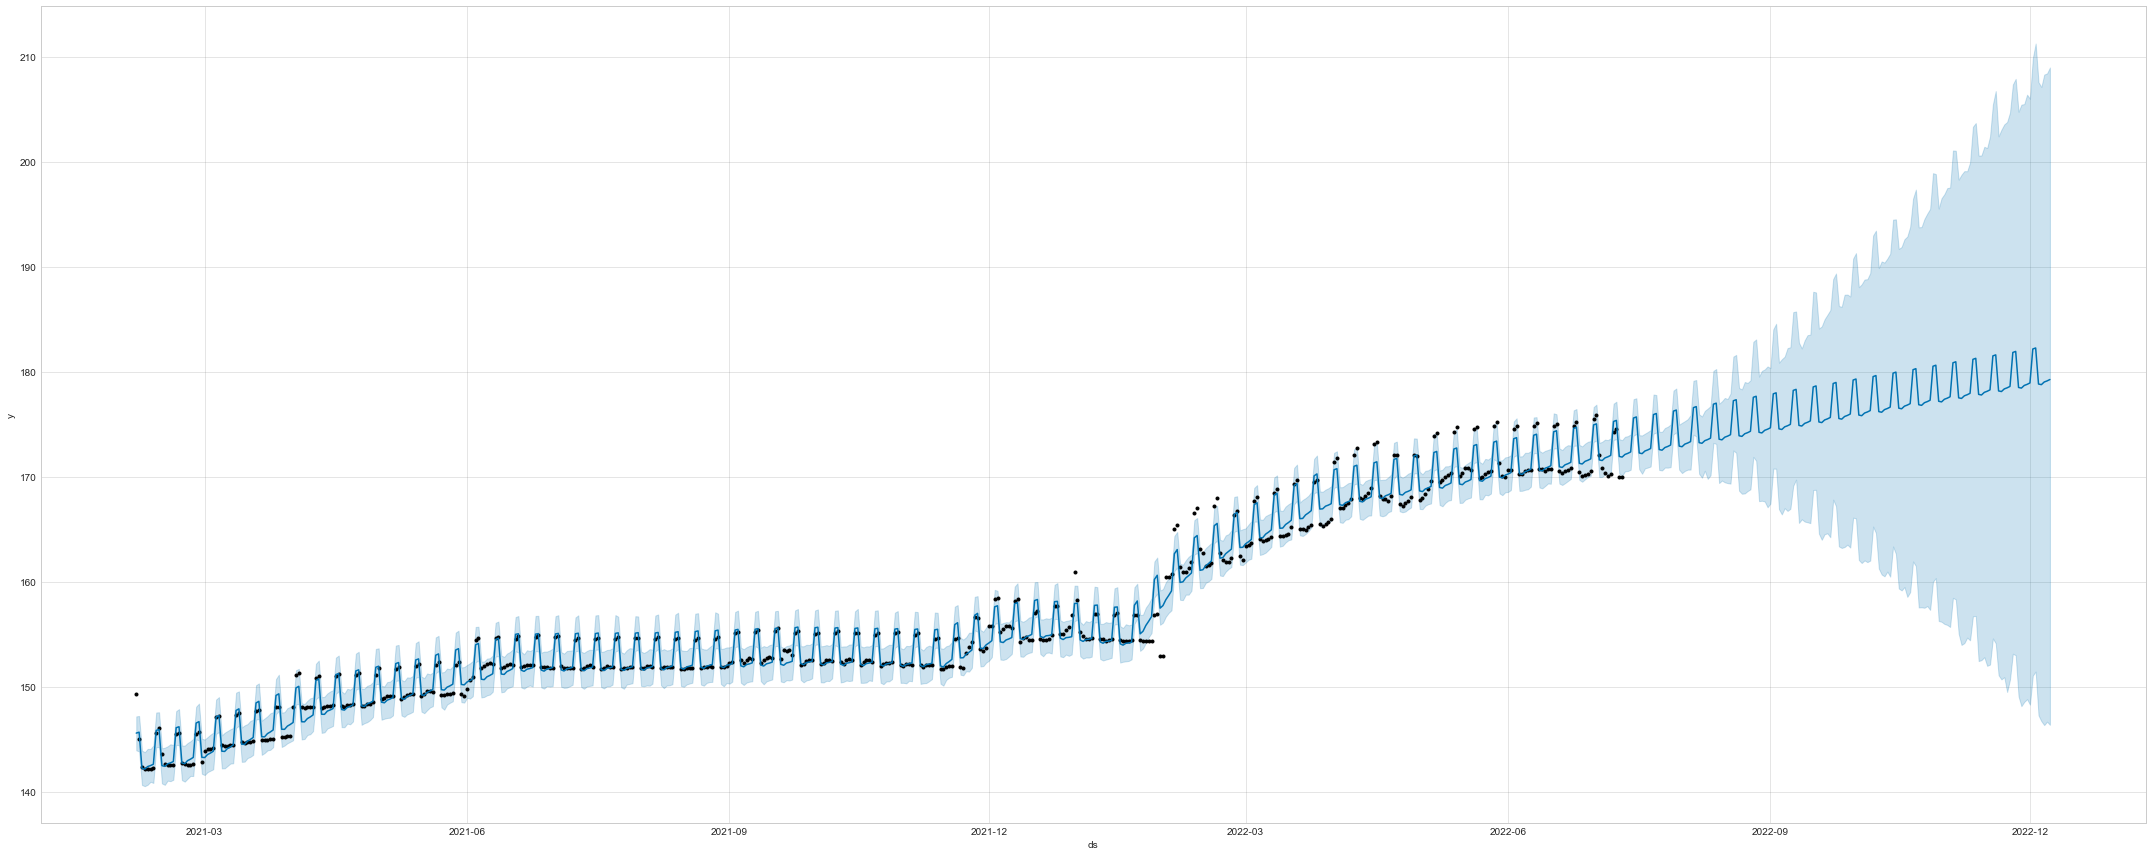

In [93]:
# Plot data.
plot= m.plot(forescast,figsize=(30, 12))

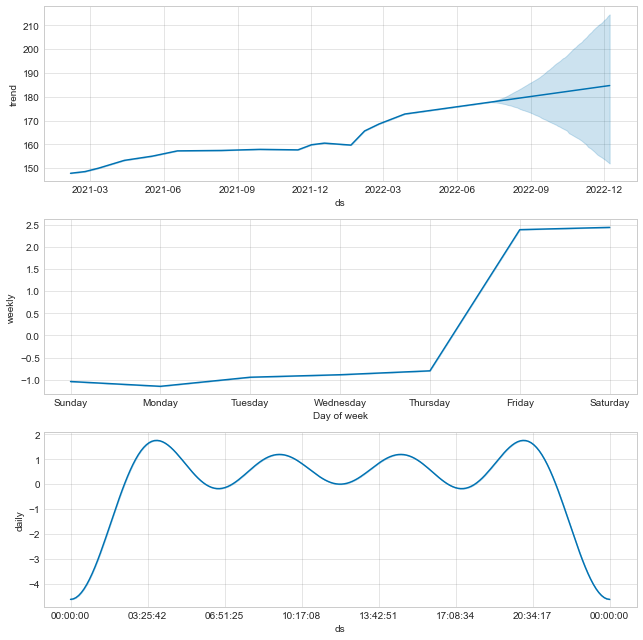

In [94]:
# graphic components forescast
plot2= m.plot_components(forescast)

In [97]:
print('MSE training: ',round(mse(pred_train['yhat'],train['y']),2))
print('RMSE training: ',round(rmse(pred_train['yhat'],train['y']),2))
print('*'*20)
print('MSE testing: ',round(mse(pred_test['yhat'],test['y']),2))
print('RMSE testing: ',round(rmse(pred_test['yhat'],test['y']),2))

MSE training:  0.74
RMSE training:  0.86
********************
MSE testing:  14.85
RMSE testing:  3.85


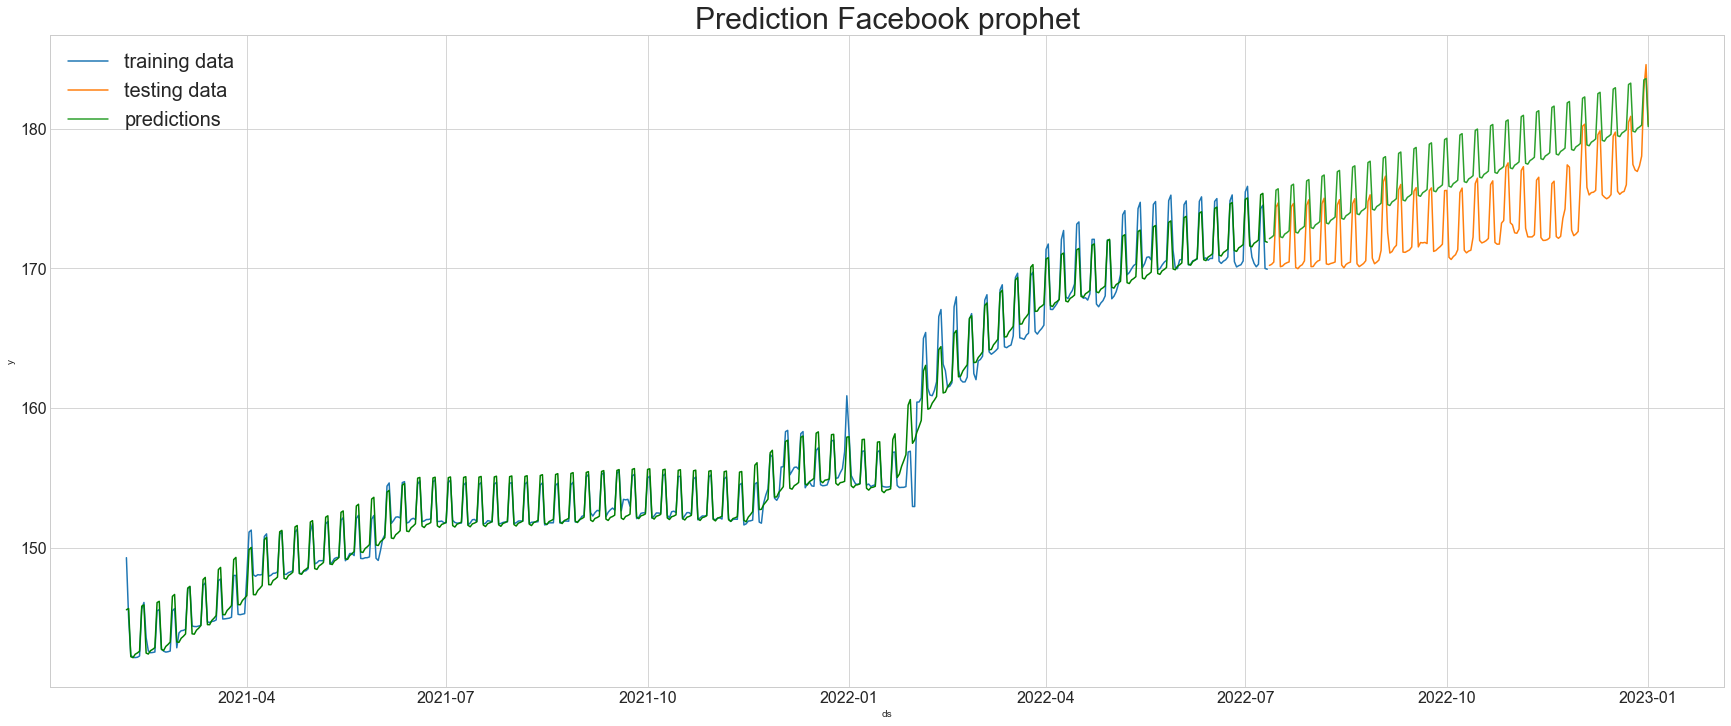

In [129]:
# Plot data.
plt.figure(figsize=(30,12))

sns.lineplot(x= 'ds', y = 'y',data=train)
sns.lineplot(x= 'ds', y = 'y',data=test)
sns.lineplot(x= 'ds', y = 'yhat',data=pred_test)
sns.lineplot(x= 'ds', y = 'yhat',data=pred_train, color= 'green')


plt.title(label = 'Prediction Facebook prophet', fontsize=30)
plt.legend(['training data','testing data','predictions'],fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show();

In [168]:
# dataframe of the predictions
df_predic=test.copy()
df_predic['yhat']=pred_test['yhat'].values
df_predic.columns=['ds','y_test','yhat_test']
df_predic

,ds,y_test,yhat_test
522,2022-07-12,170.211308,172.122344
523,2022-07-13,170.289674,172.225491
524,2022-07-14,170.450913,172.360394
525,2022-07-15,174.369141,175.593593
526,2022-07-16,174.682605,175.691774
...,...,...,...
691,2022-12-28,177.325255,180.107501
692,2022-12-29,178.026148,180.242404
693,2022-12-30,182.766028,183.475603
694,2022-12-31,184.568790,183.573784


* Using the facebook prophit model we can make predictions of the price of the listings. in this case we are going to use 75% of the data as training and 25% as testing.
* When analyzing the graphs and the values of the metrics we see that this model had a better performance than the previous model (ARIMA), in this case the facebook model tried to continue with the trend when it was given to request new values (test) .

### 6. Conclusion and recommendations:
---

To conclude with the analysis of the project, we can highlight a couple of important points about this stage of the process.
* After trying to organize the dataframes and trying various types of regression models, we can see that the models are overfitting some more than others. For example, the random forest model was one of the models that had the greatest overfitting.
* For this project I would choose the linear regression model due to the speed and the variety of options that I can have, for example being able to see the coefficients of each feature.
* Another analysis regarding the price as a function of time, were the models of ARIMA and Facebook prophet. When training and predicting the price values, we see that the models have no problems, but when it comes to predicting new data, the predictions are not very strong. However, the Facebook prophet model can follow the trend when it comes to predicting new values, this does not happen with the ARIMA model which tends follow close to the average price.

